# Projekat iz mašinskog učenja 1 (procena cena kuća)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('src')

from src.data_loader import load_data, explore_data, create_correlation_plot, select_features_by_correlation
from src.preprocessor import preprocess_data, split_data, scale_data
from src.pca_analyzer import apply_pca
from src.model_trainer import train_models, plot_cv_results
from src.evaluator import evaluate_final_models, display_results_table, plot_final_results
from src.analyzer import analyze_predictions

plt.style.use('default')
sns.set_palette("husl")

## 1. Učitavanje podataka

In [2]:
data = load_data("dataset/kc_house_data_500.csv")

Uspešno učitani podaci iz dataset/kc_house_data_500.csv
Oblik dataseta: (499, 21)
['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


## 2. Eksplorativna analiza podataka


Tipovi podataka:
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

Osnovne statistike za cenu:
count    4.990000e+02
mean     5.256699e+05
std      3.503982e+05
min      8.000000e+04
25%      3.100000e+05
50%      4.375000e+05
75%      6.400000e+05
max      3.075000e+06
Name: price, dtype: float64

Nedostajuće vrednosti:
Nema nedostajućih vrednosti!


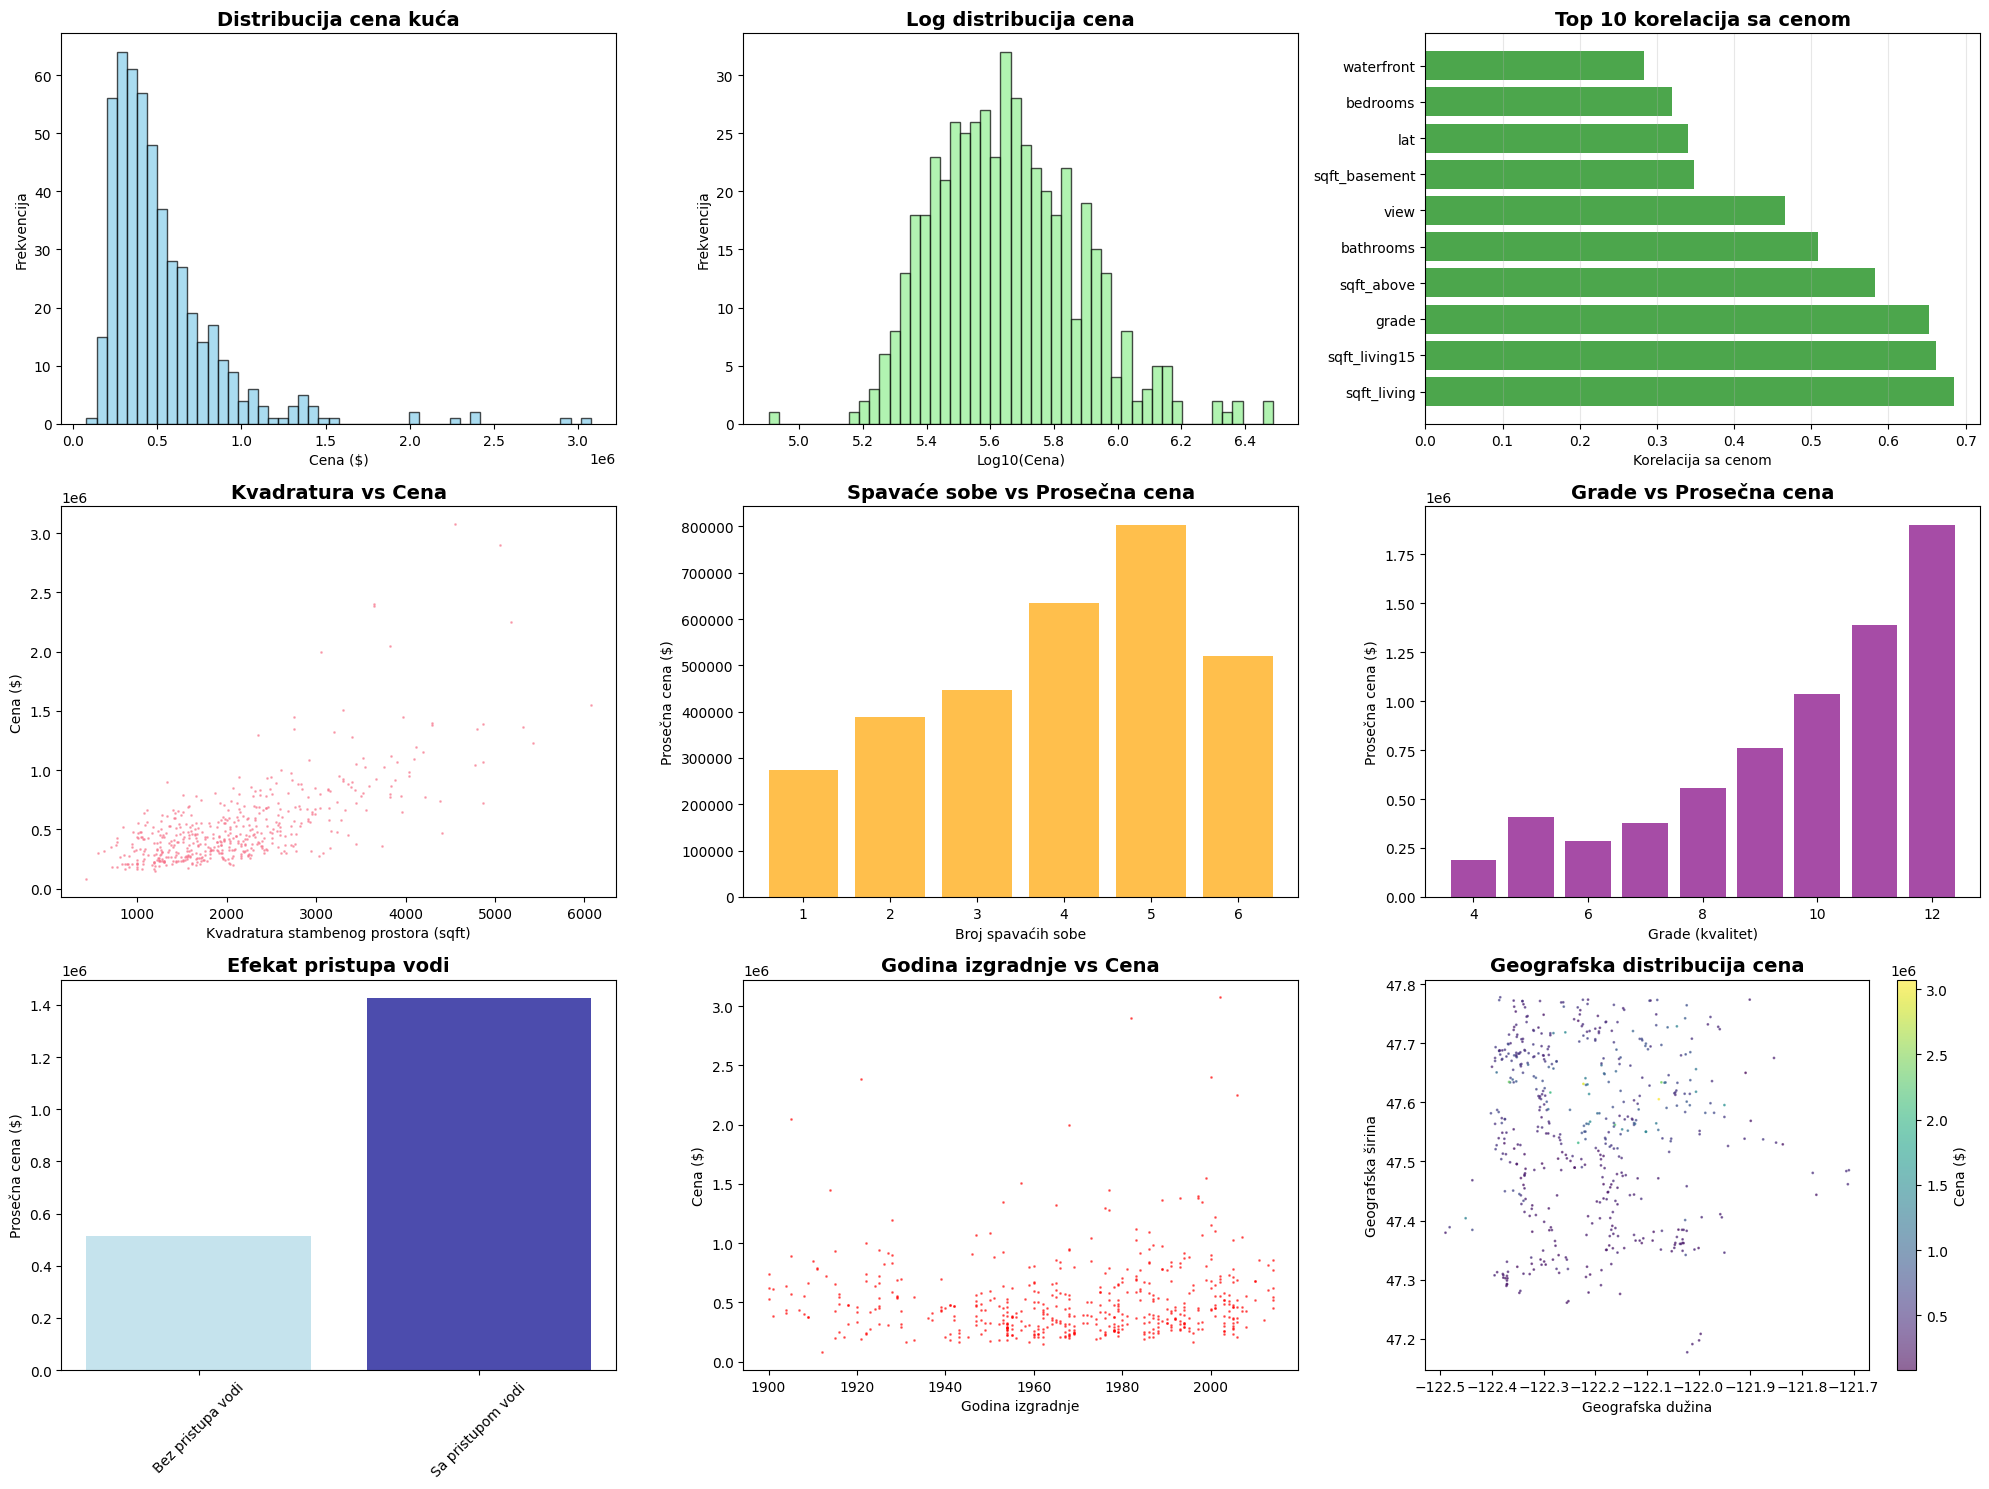


CENOVNE STATISTIKE:
Najjeftinija kuća: $80,000.00
Najskuplja kuća: $3,075,000.00
Prosečna cena: $525,669.91
Medijana cene: $437,500.00

KARAKTERISTIKE KUĆA:
Prosečna kvadratura: 2100 sqft
Prosečan broj spavaćih soba: 3.4
Prosečan broj kupatila: 2.1
Kuće sa pristupom vodi: 1.2%


In [3]:
if data is not None:
    explore_data(data)

## 3. Priprema podataka

In [4]:
if data is not None:
    # Uklanjanje suvišnih kolona + feature engineering
    df_processed = preprocess_data(data)

Uklonjene kolone: ['id', 'date']
Kreirano 5 novih feature-a: ['house_age', 'is_renovated', 'basement_ratio', 'is_large_house', 'luxury_score']


## 4. Korelaciona matrica

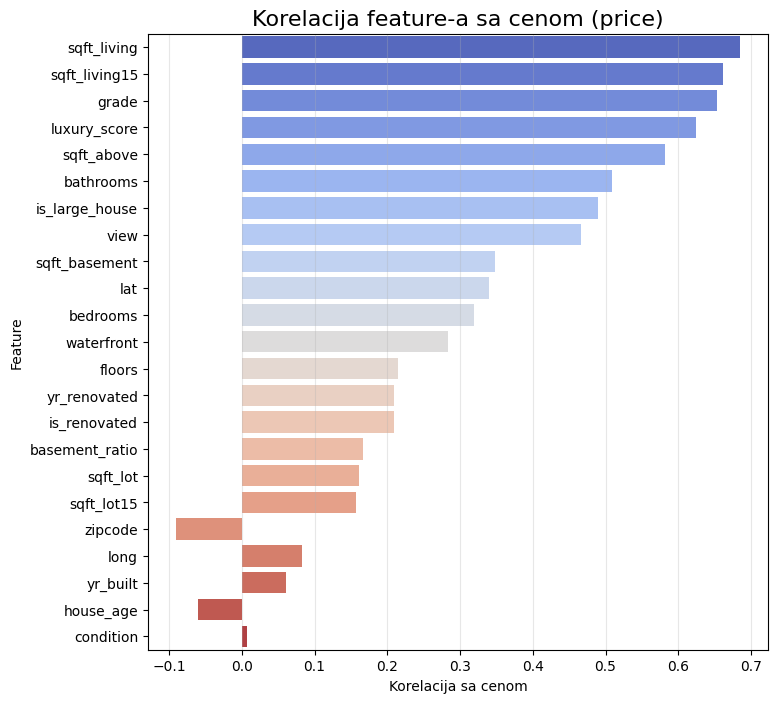

In [5]:
if df_processed is not None:
    price_corr = create_correlation_plot(df_processed)

## 5. Selekcija feature-a na osnovu korelacije

In [6]:
CORELATION_LIMIT = 0.1

if df_processed is not None:
    selected_df = select_features_by_correlation(df_processed, CORELATION_LIMIT)
    display(selected_df.head())

Feature-i sa |korelacijom| >= 0.1: 
['sqft_living', 'sqft_living15', 'grade', 'luxury_score', 'sqft_above', 'bathrooms', 'is_large_house', 'view', 'sqft_basement', 'lat', 'bedrooms', 'waterfront', 'floors', 'yr_renovated', 'is_renovated', 'basement_ratio', 'sqft_lot', 'sqft_lot15']

Izbačene kolone: 
['condition', 'yr_built', 'zipcode', 'long', 'house_age']

Oblik novog dataframe-a za učenje: (499, 19)


,sqft_living,sqft_living15,grade,luxury_score,sqft_above,bathrooms,is_large_house,view,sqft_basement,lat,bedrooms,waterfront,floors,yr_renovated,is_renovated,basement_ratio,sqft_lot,sqft_lot15,price
0,1180,1340,7,0,1180,1.00,0,0,0,47.5112,3,0,1.0,0,0,0.000000,5650,5650,221900.0
1,2570,1690,7,0,2170,2.25,1,0,400,47.7210,3,0,2.0,1991,1,0.155642,7242,7639,538000.0
2,770,2720,6,0,770,1.00,0,0,0,47.7379,2,0,1.0,0,0,0.000000,10000,8062,180000.0
3,1960,1360,7,0,1050,3.00,0,0,910,47.5208,4,0,1.0,0,0,0.464286,5000,5000,604000.0
4,1680,1800,8,0,1680,2.00,0,0,0,47.6168,3,0,1.0,0,0,0.000000,8080,7503,510000.0


## 6. Podela podataka na Train/Test i njihovo skaliranje

In [7]:
# FOR QUICK TESTING ONLY (CAP at 500)
# X = selected_df.drop('price', axis=1).iloc[:500]
# y = selected_df['price'].iloc[:500]  # target

X = selected_df.drop('price', axis=1)
y = selected_df['price'] # target

# Podela na train/test (85%/15%)
X_train, X_test, y_train, y_test = split_data(X, y)

# Skaliranje podataka
X_train_scaled, X_test_scaled, scaler = scale_data(X_train, X_test)


PODELA PODATAKA:
Train set: 424 uzoraka (85.0%)
Test set: 75 uzoraka (15.0%)

Skalirani su podaci


## 7. PCA analiza

Originalan broj feature-a: 18
Broj komponenti nakon PCA: 11
Objašnjena varijansa: 0.956 (95.6%)


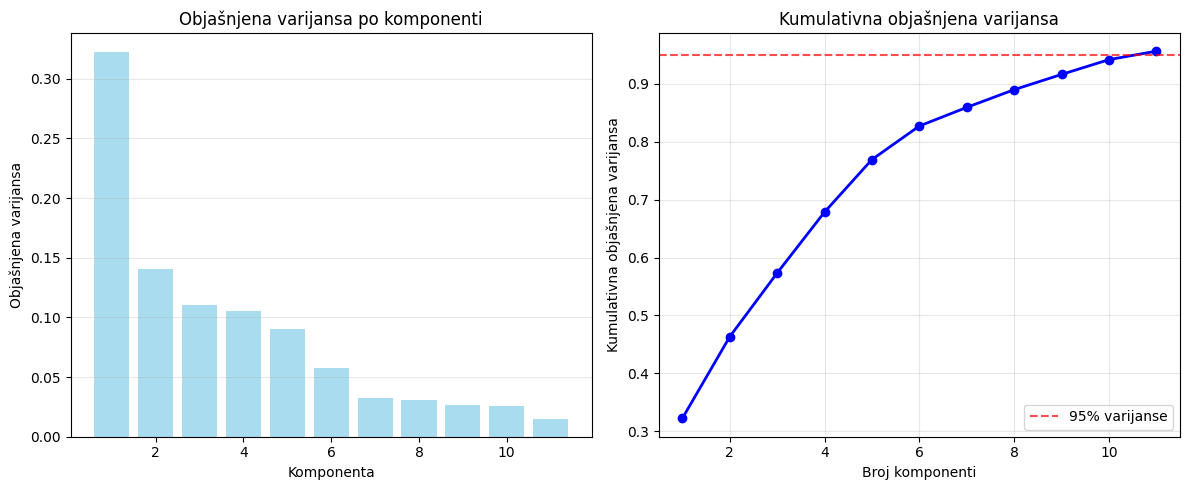


NAJVAŽNIJI FEATURE-I ZA PRVE 3 KOMPONENTE:

Komponenta 1:
  1. sqft_living: 0.395
  2. sqft_living15: 0.365
  3. sqft_above: 0.359
  4. grade: 0.358
  5. bathrooms: 0.340

Komponenta 2:
  1. basement_ratio: 0.527
  2. sqft_basement: 0.508
  3. floors: -0.350
  4. view: 0.265
  5. sqft_above: -0.256

Komponenta 3:
  1. yr_renovated: 0.575
  2. is_renovated: 0.575
  3. waterfront: -0.244
  4. luxury_score: -0.234
  5. sqft_lot15: -0.228

PCA TRANSFORMACIJA:
Originalno: 18 feature-a
Nakon PCA: 11 komponenti


In [8]:
if selected_df is not None:
    X_train_pca, X_test_pca, pca = apply_pca(X_train_scaled, X_test_scaled, X_train) # X_train služi za prikaz originalnih kolona

    print(f"\nPCA TRANSFORMACIJA:")
    print(f"Originalno: {X_train_scaled.shape[1]} feature-a")
    print(f"Nakon PCA: {X_train_pca.shape[1]} komponenti")

## 8. Treniranje modela

In [9]:
if selected_df is not None:
    results = train_models(X_train_scaled, X_train_pca, y_train)
    
    print(f"\nMODELI TRENIRANI NA:")
    print(f"Originalni (skalirani) feature-i: {X_train_scaled.shape[1]} feature-a")
    print(f"PCA komponente: {X_train_pca.shape[1]} komponenti")
    print(f"Ukupno uzoraka za treniranje: {X_train_scaled.shape[0]}")


Treniranje Linear Regression...
Cross-validation evaluacija...
Linear Regression - Završeno!
CV MSE (Original): 44,592,037,773 ± 19,968,962,742
CV MSE (PCA): 41,353,667,661 ± 18,894,288,285
CV R² (Original): 0.630 ± 0.038
CV R² (PCA): 0.655 ± 0.051

Treniranje Random Forest...
Pretraga hiperparametara (originalni prostor)...
Pretraga hiperparametara (PCA prostor)...
Cross-validation evaluacija...
Random Forest - Završeno!
CV MSE (Original): 39,255,153,650 ± 21,506,599,447
CV MSE (PCA): 38,617,102,908 ± 19,965,593,978
CV R² (Original): 0.691 ± 0.078
CV R² (PCA): 0.680 ± 0.068

Treniranje SVR...
Pretraga hiperparametara (originalni prostor)...
Pretraga hiperparametara (PCA prostor)...
Cross-validation evaluacija...
SVR - Završeno!
CV MSE (Original): 131,044,765,374 ± 57,489,950,708
CV MSE (PCA): 131,041,342,365 ± 57,490,181,869
CV R² (Original): -0.070 ± 0.044
CV R² (PCA): -0.070 ± 0.044

Treniranje KNN...
Pretraga hiperparametara (originalni prostor)...
Pretraga hiperparametara (PCA pr

## 9. Vizualizacija

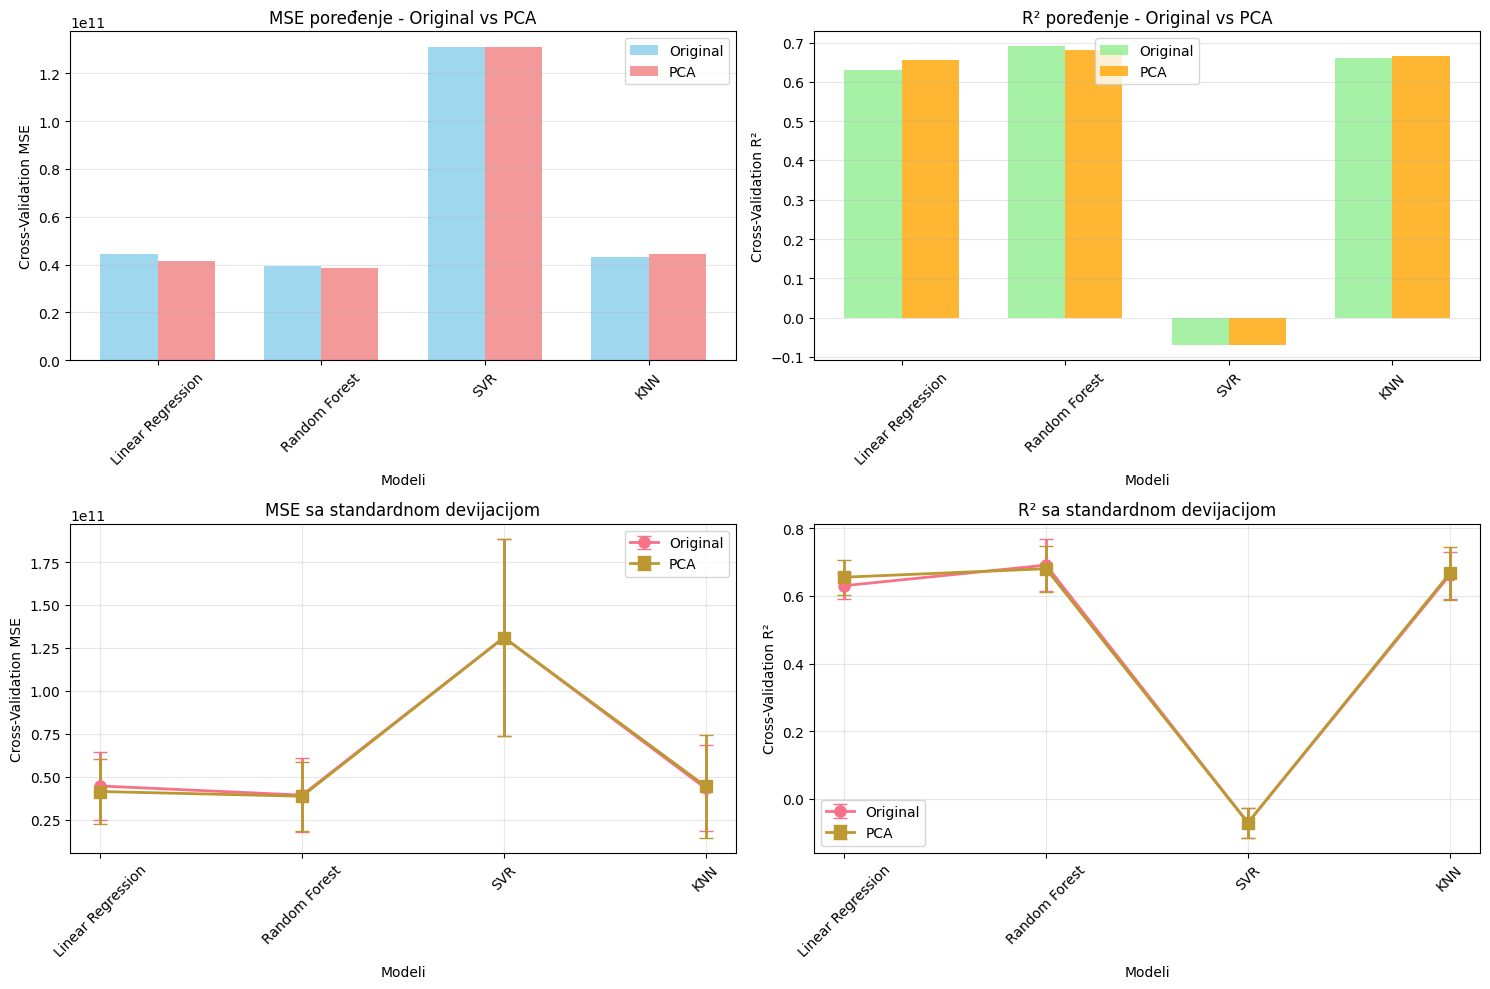

In [10]:
if selected_df is not None:
    plot_cv_results(results)

## 10. Evaluacija na test skupu

In [11]:
if selected_df is not None:
    final_results = evaluate_final_models(results, X_test_scaled, X_test_pca, y_test)
    
    print(f"\nFINALNA EVALUACIJA:")
    print(f"Test skup: {X_test_scaled.shape[0]} uzoraka")
    print(f"Feature-i (originalni): {X_test_scaled.shape[1]} skaliranih feature-a")
    print(f"Target: cene nekretnina")


Evaluacija Linear Regression...
  Najbolji prostor: PCA
  Test MAE: $122,161
  Test MSE: 34,767,720,591
  Test RMSE: $186,461
  Test R²: 0.709
  Predikcije u ±10%: 30.7%
  Predikcije u ±20%: 53.3%

Evaluacija Random Forest...
  Najbolji prostor: Original
  Test MAE: $93,256
  Test MSE: 24,339,085,061
  Test RMSE: $156,010
  Test R²: 0.796
  Predikcije u ±10%: 42.7%
  Predikcije u ±20%: 74.7%

Evaluacija SVR...
  Najbolji prostor: PCA
  Test MAE: $231,284
  Test MSE: 129,850,855,009
  Test RMSE: $360,348
  Test R²: -0.086
  Predikcije u ±10%: 17.3%
  Predikcije u ±20%: 29.3%

Evaluacija KNN...
  Najbolji prostor: PCA
  Test MAE: $126,753
  Test MSE: 44,937,257,148
  Test RMSE: $211,984
  Test R²: 0.624
  Predikcije u ±10%: 34.7%
  Predikcije u ±20%: 65.3%

FINALNA EVALUACIJA:
Test skup: 75 uzoraka
Feature-i (originalni): 18 skaliranih feature-a
Target: cene nekretnina


## 11. Upoređivanje rezultata i odabir najboljeg


TABELA SVIH REZULTATA
Model           Prostor  CV R²    Test R²  RMSE         MAE          ±10%   ±20%  
--------------------------------------------------------------------------------
Random Forest   Original 0.691    0.796    $156,010     $93,256      42.7 % 74.7 %
Linear Regression PCA      0.655    0.709    $186,461     $122,161     30.7 % 53.3 %
KNN             PCA      0.666    0.624    $211,984     $126,753     34.7 % 65.3 %
SVR             PCA      -0.070   -0.086   $360,348     $231,284     17.3 % 29.3 %
--------------------------------------------------------------------------------
NAJBOLJI MODEL: Random Forest (Original prostor)
Test R²: 0.796
RMSE: $156,010


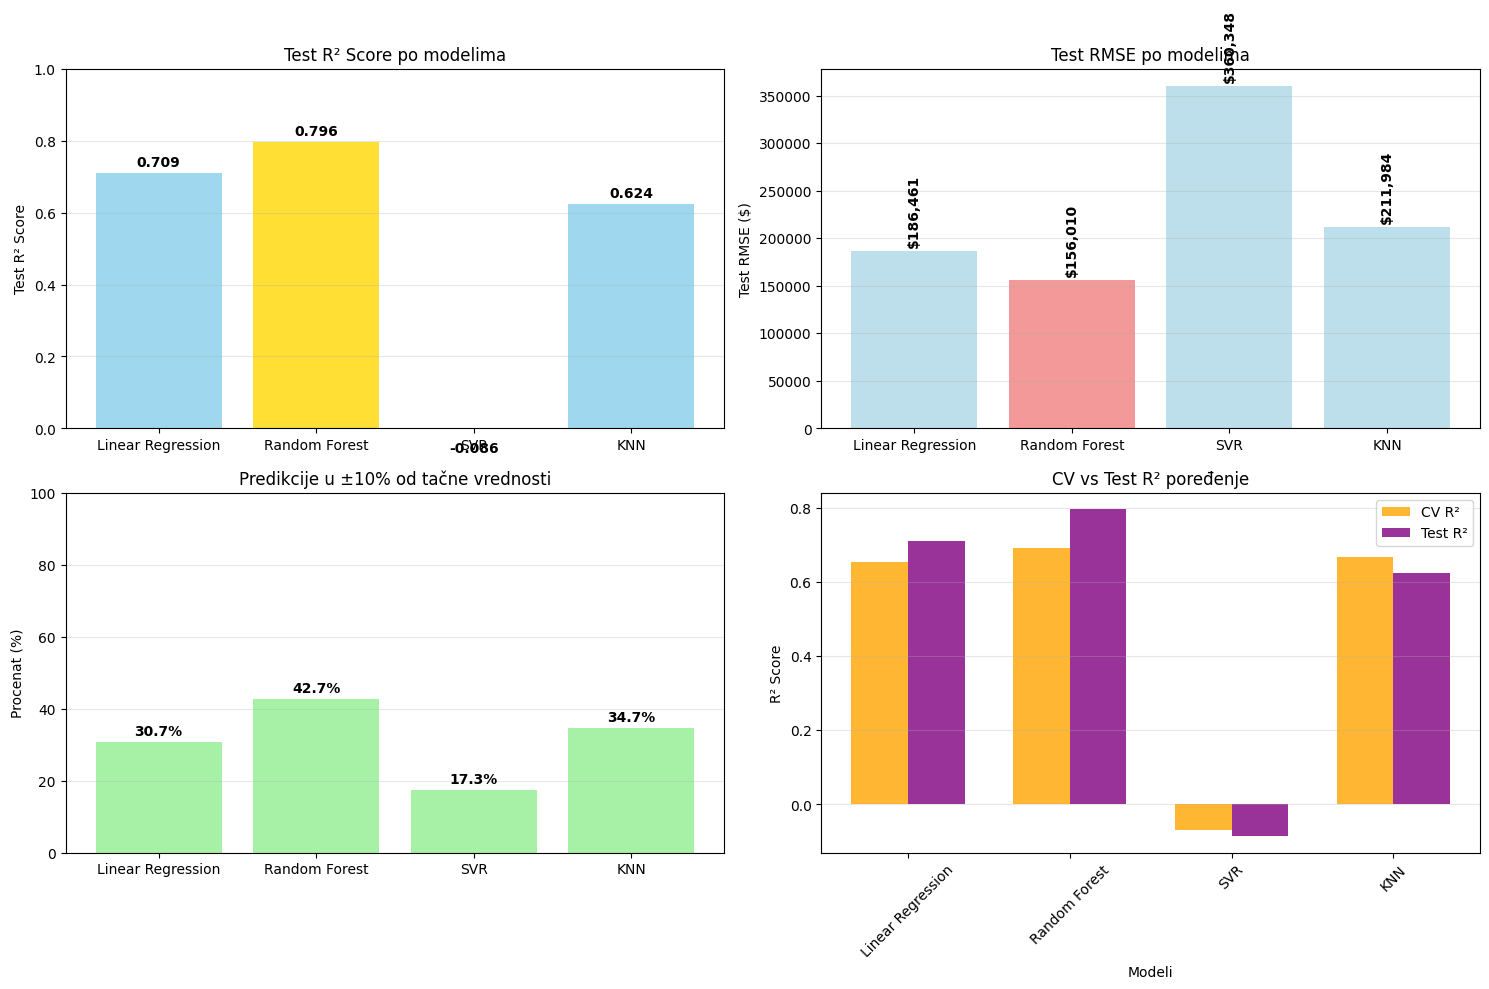

In [12]:
if selected_df is not None:
    display_results_table(final_results)
    plot_final_results(final_results)

## 12. Analiza najboljeg modela


NAJBOLJI MODEL: Random Forest
Test R²: 0.796
Test RMSE: $156,010
Prostor: Original
Treniran na 18 originalnih feature-a ili 11 PCA komponenti (prema izboru)


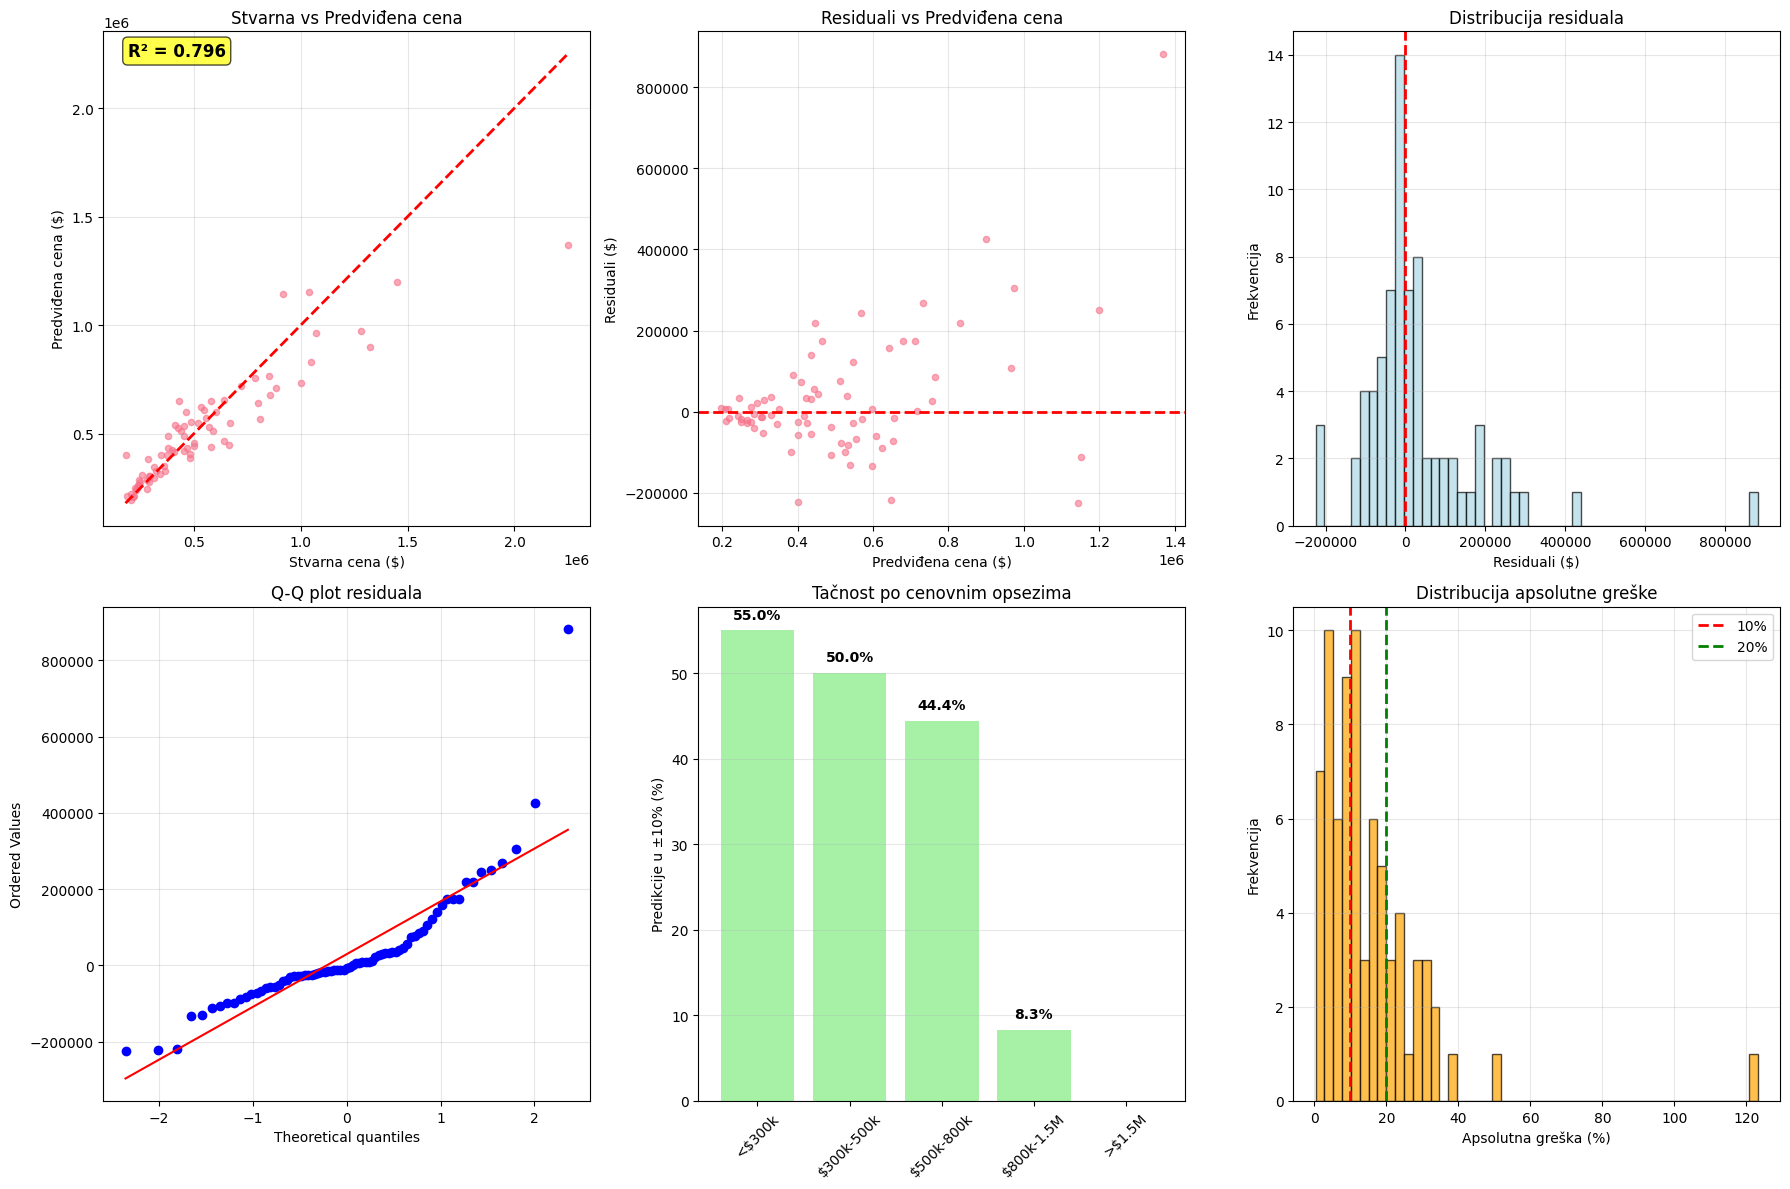


STATISTIKE GREŠAKA:
Srednja apsolutna greška: $93,256
Medijana apsolutne greške: $52,048
Standardna devijacija residuala: $153,203
Maksimalna pozitivna greška: $882,013
Maksimalna negativna greška: $-225,012

PROCENAT TAČNIH PREDIKCIJA:
U ±5%: 21.3%
U ±10%: 42.7%
U ±15%: 60.0%
U ±20%: 74.7%
U ±25%: 84.0%

5 NAJGORIH PREDIKCIJA:
Stvarna      Predviđena   Greška     Greška %  
--------------------------------------------------
$180,000     $401,762     $221,762   123.2    %
$430,000     $648,284     $218,284   50.8     %
$2,250,000   $1,367,987   $-882,013  39.2     %
$285,000     $383,845     $98,845    34.7     %
$665,000     $446,738     $-218,262  32.8     %

INFORMACIJE O FEATURE-IMA:
• Korelacijski limit: 0.1
• Broj originalnih feature-a nakon pripreme: 18
• Broj PCA komponenti: 11


In [13]:
if selected_df is not None:
    best_model_name = max(final_results.keys(), key=lambda x: final_results[x]['test_r2'])
    best_result = final_results[best_model_name]
    
    print(f"\nNAJBOLJI MODEL: {best_model_name}")
    print(f"Test R²: {best_result['test_r2']:.3f}")
    print(f"Test RMSE: ${best_result['test_rmse']:,.0f}")
    print(f"Prostor: {best_result['space_type']}")
    print(f"Treniran na {X_train_scaled.shape[1]} originalnih feature-a ili {X_train_pca.shape[1]} PCA komponenti (prema izboru)")
    
    analyze_predictions(best_result, best_model_name, y_test)
    
    print(f"\nINFORMACIJE O FEATURE-IMA:")
    print(f"• Korelacijski limit: {CORELATION_LIMIT}")
    print(f"• Broj originalnih feature-a nakon pripreme: {X_train.shape[1]}")
    print(f"• Broj PCA komponenti: {X_train_pca.shape[1]}")